Compare output from dask streaming analysis to results from Fluctana.

We calculate results from RMCs examples/nersc/check_correlation.py for Channels L0701 and L0702 to
results from the streaming analysis package.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib as mpl
mpl.rcParams["xtick.labelsize"] = "large"
mpl.rcParams["ytick.labelsize"] = "large"

import matplotlib.pyplot as plt
import adios2
from scipy.signal import stft, spectrogram, detrend

In [3]:
import sys
sys.path.append("/global/homes/r/rkube/repos/delta")
from analysis.channels import channel

In [4]:
win = np.hanning(512)
win_factor = np.mean(win**2) 
print("win_Factor = ", win_factor)

win_Factor =  0.374267578125


In [5]:
# Run the fluctana code from RMCs examples/nersc/check_correlation.py

In [136]:
def test_rmc():
    import sys
    sys.path.append("/global/homes/r/rkube/repos/fluctana_rmc")
    from fluctana import FluctAna, KstarEcei

    shot = 18431
    trange = [-0.10, -0.08]
    clist = [['ECEI_L0702'], ['ECEI_L1601']]

    # call fluctana
    A = FluctAna()

    # add data
    A.add_data(KstarEcei(shot=shot, clist=clist[0], data_path='/global/cscratch1/sd/rkube/KSTAR/kstar_streaming/'), trange=trange, norm=1)
    A.add_data(KstarEcei(shot=shot, clist=clist[1], data_path='/global/cscratch1/sd/rkube/KSTAR/kstar_streaming/'), trange=trange, norm=1)

    # do fft; full = 1 
    A.fftbins(nfft=2048, window='hann', overlap=0.5, detrend=0, full=1)

    # calculate correlation using data sets done and dtwo. results are saved in A.Dlist[dtwo].val
    A.bicoherence(done=0, dtwo=1)

    # plot the results; dnum = data set number, cnl = channel number list to plot
    #A.mplot(dnum=1,cnl=range(len(A.Dlist[1].clist)),type='val')
    
    return(A)

In [125]:
def fftbins(x, dt, nfft, window, overlap, do_detrend, full):
    # IN : 1 x tnum data
    # OUT : bins x faxis fftdata
    tnum = len(x)
    
    bins = int(np.fix((int(tnum/nfft) - overlap)/(1.0 - overlap)))
    win = np.hanning(nfft)
    #bins, win = fft_window(tnum, nfft, window, overlap)
    win_factor = np.mean(win**2)  # window factors
    print("***fftbins: win_factor = {0:f}".format(win_factor))

    # make an x-axis #
    ax = np.fft.fftfreq(nfft, d=dt) # full 0~fN -fN~-f1
    if np.mod(nfft, 2) == 0:  # even nfft
        ax = np.hstack([ax[0:int(nfft/2)], -(ax[int(nfft/2)]), ax[int(nfft/2):nfft]])
    if full == 1: # full shift to -fN ~ 0 ~ fN
        ax = np.fft.fftshift(ax)
    else: # half 0~fN
        ax = ax[0:int(nfft/2+1)]

    # make fftdata
    if full == 1: # full shift to -fN ~ 0 ~ fN
        if np.mod(nfft, 2) == 0:  # even nfft
            fftdata = np.zeros((bins, nfft+1), dtype=np.complex_)
        else:  # odd nfft
            fftdata = np.zeros((bins, nfft), dtype=np.complex_)
    else: # half 0 ~ fN
        fftdata = np.zeros((bins, int(nfft/2+1)), dtype=np.complex_)

    for b in range(bins):
        idx1 = int(b*np.fix(nfft*(1 - overlap)))
        idx2 = idx1 + nfft
        #print("***bin {0:d}, idx1 = {1:d}, idx2 = {2:d}".format(b, idx1, idx2))

        sx = x[idx1:idx2]

        if do_detrend == 1:
            sx = detrend(sx, type='linear')
        sx = detrend(sx, type='constant')  # subtract mean
        sx = sx * win  # apply window function

        # get fft
        SX = np.fft.fft(sx, n=nfft)/nfft  # divide by the length
        if np.mod(nfft, 2) == 0:  # even nfft
            SX = np.hstack([SX[0:int(nfft/2)], np.conj(SX[int(nfft/2)]), SX[int(nfft/2):nfft]])
        if full == 1: # shift to -fN ~ 0 ~ fN
            SX = np.fft.fftshift(SX)
        else: # half 0 ~ fN
            SX = SX[0:int(nfft/2+1)]

        fftdata[b,:] = SX

    return ax, fftdata, win_factor

Rading init: 
Data is normalized by trange average ECEI
LOW signal level channel ECEI_L0702, ref = 100%, siglevel = -0.0003 V
Rading init: 
Data is normalized by trange average ECEI
LOW signal level channel ECEI_L1601, ref = 100%, siglevel = -0.003 V
***fftbins: win_factor = 0.374817
dnum 0 fftbins 7 with hann size 2048 overlap 0.5 detrend 0 full 1
***fftbins: win_factor = 0.374817
dnum 1 fftbins 7 with hann size 2048 overlap 0.5 detrend 0 full 1
***** bichoerence: shape(1) =  (2049, 1025) (2049,)
*****  [0.02322968 0.11352164 0.03719849 0.27344122 0.14849118 0.15030796
 0.27942524 0.13062604 0.16889911 0.12645743 0.17215145 0.1565622
 0.18814068 0.20297472 0.12207399 0.19406967 0.18149328 0.06577742
 0.14103737 0.11448165]


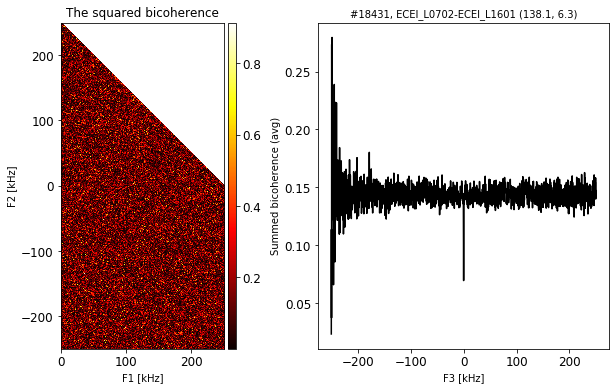

In [137]:
A = test_rmc()

In [138]:
L0701_fa = np.squeeze(A.Dlist[0].data)
L0701_ax, L0701_ft, win_factor = fftbins(L0701_fa, dt=2e-6, nfft=2048, window="hann", overlap=0.5, do_detrend=0, full=1)

L0702_fa = np.squeeze(A.Dlist[1].data)
L0702ax, L0702_ft, win_factor = fftbins(L0702_fa, dt=2e-6, nfft=2048, window="hann", overlap=0.5, do_detrend=0, full=1)

***fftbins: win_factor = 0.374817
***fftbins: win_factor = 0.374817


In [139]:
def bicoherence(XX, YY):
    # ax1 = self.Dlist[dtwo].ax # full -fN ~ fN
    # ax2 = np.fft.ifftshift(self.Dlist[dtwo].ax) # full 0 ~ fN, -fN ~ -f1
    # ax2 = ax2[0:int(nfft/2+1)] # half 0 ~ fN

    bins = len(XX)
    full = len(XX[0,:]) # full length
    half = int(full/2+1) # half length

    # calculate bicoherence
    B = np.zeros((full, half), dtype=np.complex_)
    P12 = np.zeros((full, half))
    P3 = np.zeros((full, half))
    val = np.zeros((full, half))

    for b in range(bins):
        X = XX[b,:] # full -fN ~ fN
        Y = YY[b,:] # full -fN ~ fN

        Xhalf = np.fft.ifftshift(X) # full 0 ~ fN, -fN ~ -f1
        Xhalf = Xhalf[0:half] # half 0 ~ fN

        X1 = np.transpose(np.tile(X, (half, 1)))
        X2 = np.tile(Xhalf, (full, 1))
        X3 = np.zeros((full, half), dtype=np.complex_)
        for j in range(half):
            if j == 0:
                X3[0:, j] = Y[j:]
            else:
                X3[0:(-j), j] = Y[j:]

        B = B + X1 * X2 * np.matrix.conjugate(X3) / bins #  complex bin average
        P12 = P12 + (np.abs(X1 * X2).real)**2 / bins # real average
        P3 = P3 + (np.abs(X3).real)**2 / bins # real average

    # val = np.log10(np.abs(B)**2) # bispectrum
    val = (np.abs(B)**2) / P12 / P3 # bicoherence

    # summation over pairs
    sum_val = np.zeros(full)
    for i in range(half):
        if i == 0:
            sum_val = sum_val + val[:,i]
        else:
            sum_val[i:] = sum_val[i:] + val[:-i,i]

    N = np.array([i+1 for i in range(half)] + [half for i in range(full-half)])
    sum_val = sum_val / N # element wise division

    return val, sum_val

In [148]:
c1 = channel('L', 7, 2)
c2 = channel('L', 16, 1)

print("Channel 1: ", c1, ", idx = ", c1.idx())
print("Channel 2: ", c2, ", idx = ", c2.idx())

with np.load("../test_data/io_array_tr_s0001.npz") as df:
    # Load transformed data, as generated by datareader
    io_array_tr = df["io_array"]
    print("io_array_tr.shape = ", io_array_tr.shape)

with np.load("../test_data/fft_data_s0001.npz") as df:
    # Load FFT data, as calculated by processor.
    fft_data = df["fft_data"]
    print("fft_data.shape = ", fft_data.shape)
    
with np.load("../test_data/ralphs_task_001.npz") as df:
    # Load results from dask tasks
    ralphs_task = df["res"]
    
fft_data = np.fft.fftshift(fft_data, axes=1)

print("io_array_ft.shape = ", io_array_ft.shape)
print("Channel idx for ", c1, ": {0:d}".format(c1.idx()), " for ", c1, ", {0:d}".format(c2.idx()))

Channel 1:  L0702 , idx =  49
Channel 2:  L1601 , idx =  120
io_array_tr.shape =  (192, 10000)
fft_data.shape =  (192, 2048, 8)
io_array_ft.shape =  (192, 2048, 5)
Channel idx for  L0702 : 49  for  L0702 , 120


In [144]:
ralphs_task.shape

(3, 2048, 1025)

Text(0.5, 1.0, 'Channel L1601')

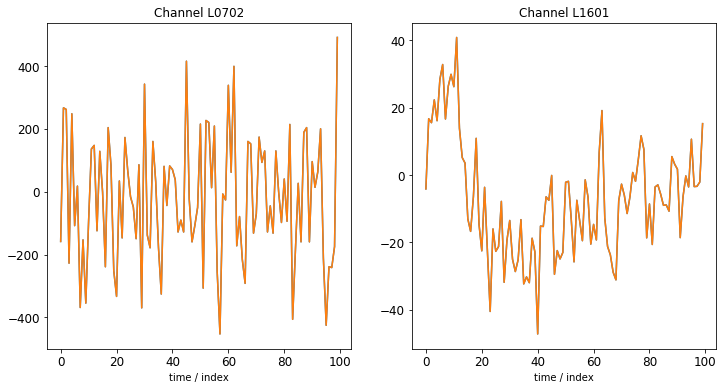

In [142]:
plt.figure(figsize=(12, 6))
plt.subplot(121)

plt.plot(io_array_tr[c1.idx(),:100])
plt.plot(L0701_fa[:100])
plt.xlabel("time / index")
plt.title("Channel " + str(c1))

plt.subplot(122)
plt.plot(io_array_tr[c2.idx(),:100])
plt.plot(L0702_fa[:100])
plt.xlabel("time / index")
plt.title("Channel " + str(c2))

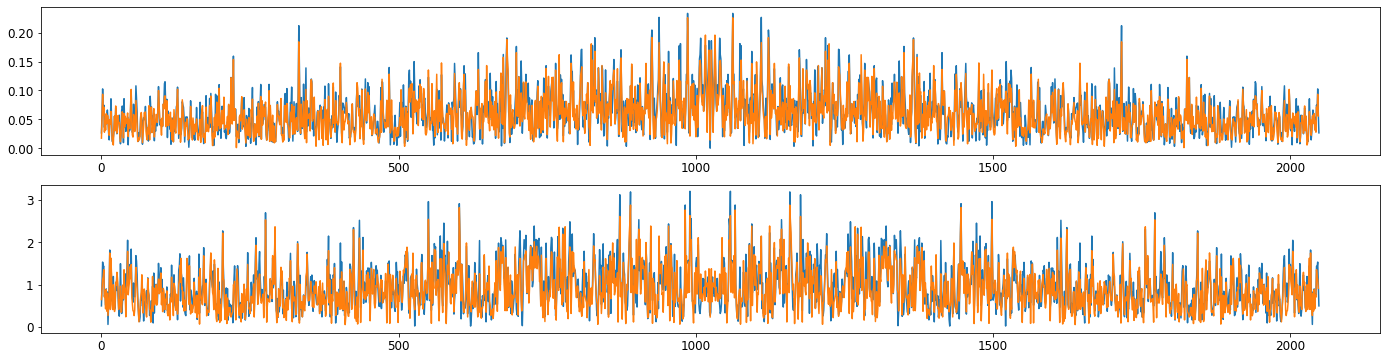

In [75]:
plt.figure(figsize=(24, 6))

plt.subplot(211)
plt.plot(np.abs(L0701_ft.mean(axis=0)))
#plt.plot(np.abs(A.Dlist[0].spdata[0, :, :].mean(axis=0)))
plt.plot(np.abs(fft_data[c1.idx(), :, :].mean(axis=1)) * 0.5)

plt.subplot(212)
plt.plot(np.abs(L0702_ft.mean(axis=0)))
#plt.plot(np.abs(A.Dlist[1].spdata[0, :, :].mean(axis=0)))
plt.plot(np.abs(fft_data[c2.idx(), :, :].mean(axis=1)) * 0.5)

In [51]:
print(A.Dlist[0].spdata[0, :, :].shape, A.Dlist[1].spdata[0, :, :].shape)
print(fft_data[c1.idx(), :, :].shape, fft_data[c2.idx(), :, :].shape)

(7, 2049) (7, 2049)
(2048, 8) (2048, 8)


In [52]:
my_bc1 = bicoherence(A.Dlist[0].spdata[0, :, :], A.Dlist[1].spdata[0, :, :])
my_bc2 = bicoherence(fft_data[c1.idx(), :, :].T, fft_data[c2.idx(), :, :].T)

In [135]:
fft_data[c1.idx(), :, :].T.shape

(8, 2048)

In [53]:
print(my_bc1[0].shape, my_bc1[1].shape)
print(my_bc2[0].shape, my_bc2[1].shape)

(2049, 1025) (2049,)
(2048, 1025) (2048,)


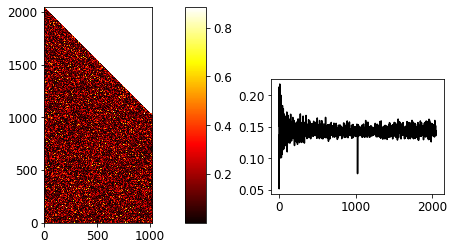

In [94]:
fig = plt.figure()
ax_bc = fig.add_axes([0.15, 0.2, 0.3, 0.75])
ax_cb = fig.add_axes([0.5, 0.2, 0.05, 0.75])
ax_fs = fig.add_axes([0.7, 0.3, 0.4, 0.4])

bc = ax_bc.imshow(my_bc1[0], origin='lower', cmap=plt.cm.hot)
fig.colorbar(bc, cax=ax_cb)
ax_fs.plot(my_bc1[1], 'k')

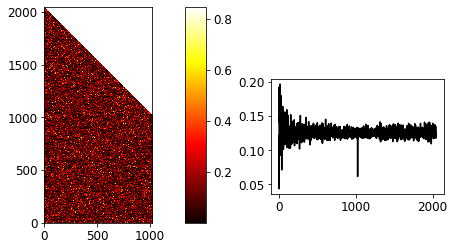

In [96]:
fig = plt.figure()
ax_bc = fig.add_axes([0.15, 0.2, 0.3, 0.75])
ax_cb = fig.add_axes([0.5, 0.2, 0.05, 0.75])
ax_fs = fig.add_axes([0.7, 0.3, 0.4, 0.4])

bc = ax_bc.imshow(my_bc2[0], origin='lower', cmap=plt.cm.hot)
fig.colorbar(bc, cax=ax_cb)
ax_fs.plot(my_bc2[1], 'k')

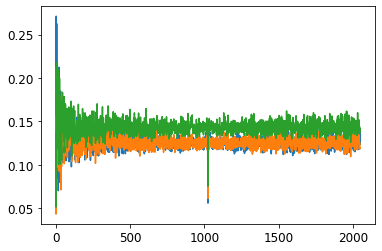

In [158]:
plt.plot(ralphs_task[1,:])
plt.plot(my_bc2[1])
plt.plot(my_bc1[1])

Text(0, 0.5, 'Summed bicoherence (avg)')

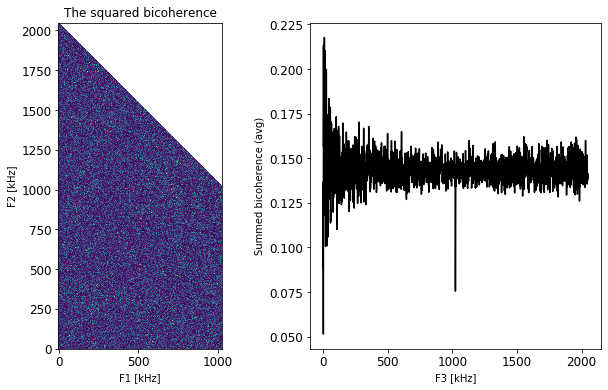

In [85]:
#pshot = self.Dlist[dtwo].shot
#chpos = '({:.1f}, {:.1f})'.format(self.Dlist[dtwo].rpos[dtwo_subset[c]]*100, self.Dlist[dtwo].zpos[dtwo_subset[c]]*100) # [cm]

# Plot results
fig, (a1,a2) = plt.subplots(1,2, figsize=(10,6), gridspec_kw = {'width_ratios':[1,1.5]})
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
 
#pax1 = ax1/1000.0 # [kHz]
#pax2 = ax2/1000.0 # [kHz]

pdata = my_bc1[0]
pdata2 = my_bc1[1]

#pdata = self.Dlist[dtwo].val[c,:,:]
#pdata2 = self.Dlist[dtwo].val2[c,:]

im = a1.imshow(pdata, #extent=(pax2.min(), pax2.max(), pax1.min(), pax1.max()), 
               interpolation='none', aspect='equal', origin='lower')
a1.set_xlabel('F1 [kHz]')
a1.set_ylabel('F2 [kHz]')
a1.set_title('The squared bicoherence')
#divider = make_axes_locatable(a1)
#cax = divider.append_axes('right', size='5%', pad=0.05)
#fig.colorbar(im, cax=cax, orientation='vertical')

a2.plot(pdata2, 'k')
#a2.set_xlim([0,pax2[-1]])
a2.set_xlabel('F3 [kHz]')
a2.set_ylabel('Summed bicoherence (avg)')
#a2.set_title('#{:d}, {:s}-{:s} {:s}'.format(pshot, rname, pname, chpos), fontsize=10)